In [8]:
%reset -f
import numpy as np
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report, roc_curve, roc_auc_score
import matplotlib.pyplot as plt
from utility_show import plot_confusion_matrix

## Load results

In [22]:
file_result = './outputs/EffB2_crop288_test.npz'
# load results
result = np.load(file_result)
dev_list  = result['list_dev'].tolist()

# score_mat[dev_i][res_i][dev_j,1] = score between residue of device i (i.e., res_i) and prnu of device i (i.e., dev_j)
score_mat = result['score_mat'][1]
dev_labels = [x for x in dev_list]
elapsed_time_list = result['time_list']
avg_time = np.mean(elapsed_time_list[1:])

## Visualize confusion matrix for the closed-set problem

Classification on 87 devices on single images
Accuracy score: 0.88713


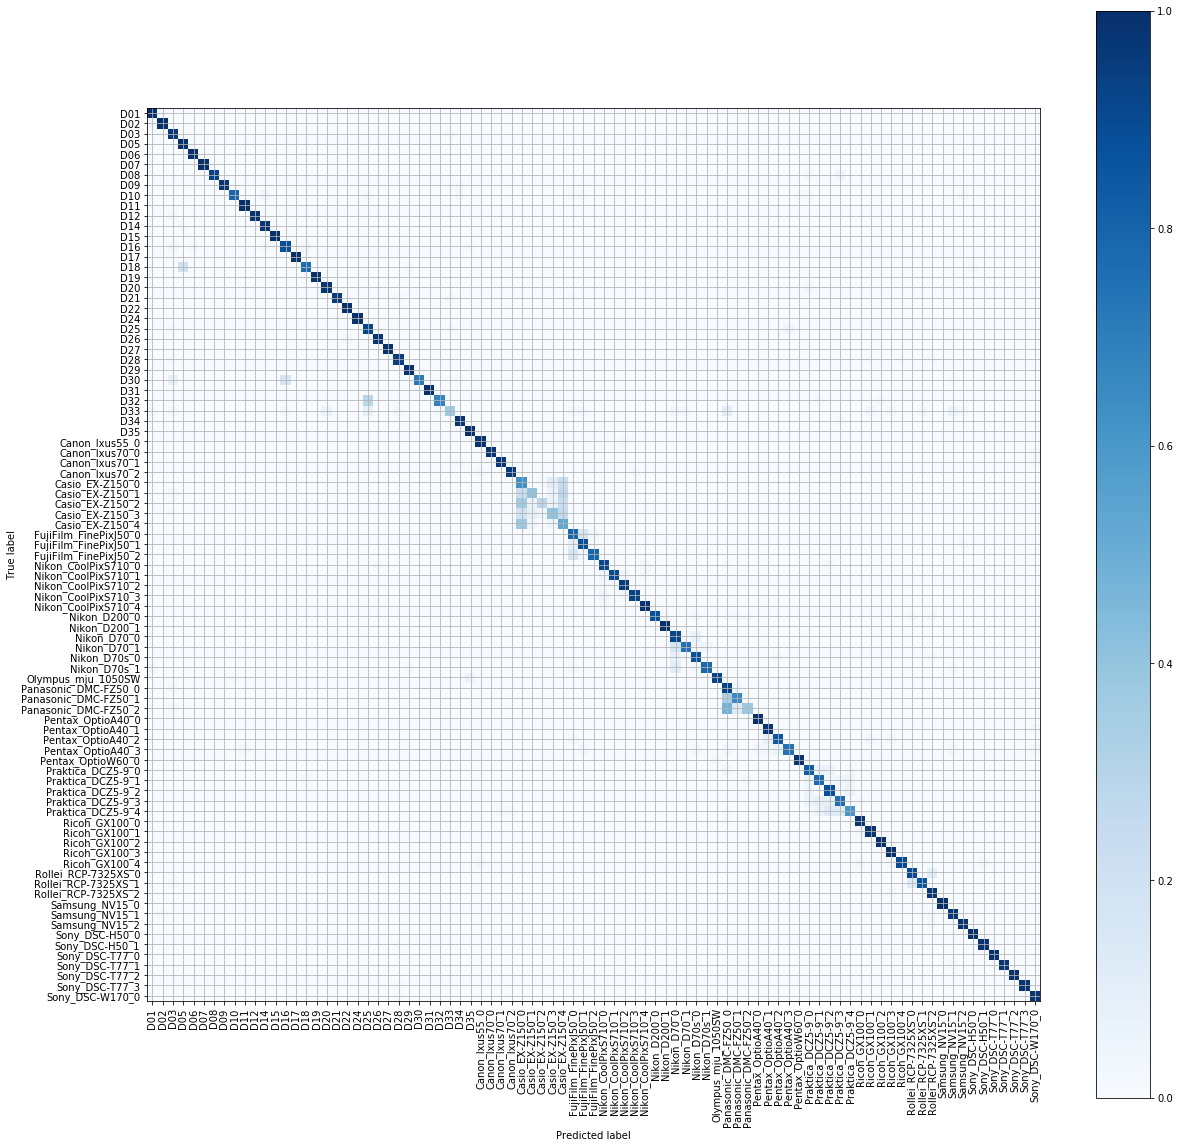

In [23]:
num_dev = len(dev_list)
score_img = [np.concatenate(item ,-1) for item in score_mat] # score_img[dev_i][dev_j,res_i]

device_true = [index*np.ones(item.shape[-1]) for index, item in enumerate(score_img)]
device_pred = [np.argmax(item, axis=0) for item in score_img]
device_true = np.concatenate(device_true,-1)
device_pred = np.concatenate(device_pred,-1)

cm = confusion_matrix(device_true, device_pred)
# plot normalized confusion matrix
cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

# accuracy score
skl_acc = accuracy_score(device_true, device_pred)
print('Classification on %d devices on single images' % num_dev)
print('Accuracy score: %5.5f' % skl_acc)

%matplotlib inline
f = plt.figure(figsize=(20,20),facecolor='white',edgecolor='black')
plot_confusion_matrix(cm=cm, classes=dev_labels)
plt.grid(color=[.7, .7, .7])

plt.rcParams['axes.axisbelow'] = True
plt.rc('xtick', labelsize=10)    
plt.rc('ytick', labelsize=10)  

## Visualize ROC curve for the binary classification problem (open set)

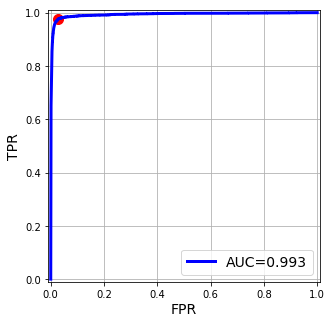

Binary Classification on single images for 87 devices
AUC=0.993
Max ACC=0.974 at th=0.695821
TPR @0.01 = 0.9318


In [24]:
label_binary = [None,]*num_dev
for index in range(num_dev):
    label_binary[index] = np.zeros(score_img[index].shape, np.int32)
    label_binary[index][index,:] = 1

score_binary = np.concatenate(score_img ,-1).flatten()
label_binary = np.concatenate(label_binary,-1).flatten()

fpr, tpr, thresholds = roc_curve(label_binary,score_binary)
acc = (tpr + (1-fpr))/2;
auc = roc_auc_score(label_binary,score_binary)
index_max = np.argmax(acc);

fp_sort = sorted(fpr)
tp_sort = sorted(tpr)
idx_order = np.argsort(tpr)

tpr_001_ind = [i for (i, val) in enumerate(fp_sort) if val >= 0.01][0]
tpr_001 = tp_sort[tpr_001_ind]

plt.figure(figsize=(8,5),facecolor='white',edgecolor='black');
plt.plot(fpr, tpr, '-b', linewidth=3.0); plt.grid(True); 
plt.axis('square')
plt.scatter(fpr[index_max], tpr[index_max], 100, 'r')
plt.xlabel('FPR', fontsize=14); plt.ylabel('TPR', fontsize=14); 
plt.xlim([-0.01,1.01]); plt.ylim([-0.01,1.01])
plt.legend({'AUC=%5.3f'%auc}, fontsize=14, loc=4)
plt.show()
print('Binary Classification on single images for %d devices' % num_dev)
print('AUC=%5.3f' % auc)
print('Max ACC=%5.3f at th=%g' % (acc[index_max], thresholds[index_max]))
print('TPR @0.01 = %5.4f' % tpr_001)